In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras import backend as K

In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    # Calculate the correct reshape dimensions based on output_shape
    # The calculation needs to be adjusted for different image sizes
    reshape_dim = (output_shape[0] // 4, output_shape[1] // 4, 64)

    # Fix: Adjust the dense layer units to match the reshape dimensions
    # Calculate the number of units needed for the Dense layer
    dense_units = reshape_dim[0] * reshape_dim[1] * reshape_dim[2]
    x = layers.Dense(dense_units, activation="relu")(latent_inputs)  # Changed to dense_units

    x = layers.Reshape(reshape_dim)(x) # Reshape based on output shape
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(output_shape[-1], 3, activation="sigmoid", padding="same")(x)
    return Model(latent_inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [17]:
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))
    return reconstruction_loss

latent_dim = 2
input_shape = (28, 28, 1)
output_shape = input_shape

encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, output_shape)
vae = VAE(encoder, decoder)

vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=vae_loss)

In [18]:
def preprocess_data(x):
    x = x.astype("float32") / 255.0
    if len(x.shape) == 3:
        x = np.expand_dims(x, -1)  # Adding channel dimension for MNIST-like datasets
    return x

(x_train_mnist, _), (x_test_mnist, _) = mnist.load_data()
x_train_mnist, x_test_mnist = preprocess_data(x_train_mnist), preprocess_data(x_test_mnist)

(x_train_fmnist, _), (x_test_fmnist, _) = fashion_mnist.load_data()
x_train_fmnist, x_test_fmnist = preprocess_data(x_train_fmnist), preprocess_data(x_test_fmnist)

(x_train_cifar, _), (x_test_cifar, _) = cifar10.load_data()
x_train_cifar, x_test_cifar = preprocess_data(x_train_cifar), preprocess_data(x_test_cifar)

# Use smaller training set for quicker comparison
x_train_mnist = x_train_mnist[:20000]
x_train_fmnist = x_train_fmnist[:20000]
x_train_cifar = x_train_cifar[:20000]

In [19]:
# MNIST Training
vae.fit(x_train_mnist, x_train_mnist, epochs=10, batch_size=128)

# Fashion MNIST Training
vae.fit(x_train_fmnist, x_train_fmnist, epochs=10, batch_size=128)

# CIFAR-10 Training
# Note: CIFAR-10 has different shape, so the encoder and decoder input/output shapes need adjusting.
input_shape_cifar = (32, 32, 3)
output_shape_cifar = input_shape_cifar
encoder_cifar = build_encoder(input_shape_cifar, latent_dim)
decoder_cifar = build_decoder(latent_dim, output_shape_cifar)
vae_cifar = VAE(encoder_cifar, decoder_cifar)
vae_cifar.compile(optimizer=tf.keras.optimizers.Adam(), loss=vae_loss)
vae_cifar.fit(x_train_cifar, x_train_cifar, epochs=10, batch_size=128)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - loss: 0.1316
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - loss: 0.0686
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 0.0678
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - loss: 0.0677
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 177ms/step - loss: 0.0679
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 0.0676
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 0.0678
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 0.0676
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 0.0675
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 0.0676
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - loss: 0.0935
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - loss: 0.0871
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - loss: 0.0872
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 0.0869
Epoch 5/10
157/157 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


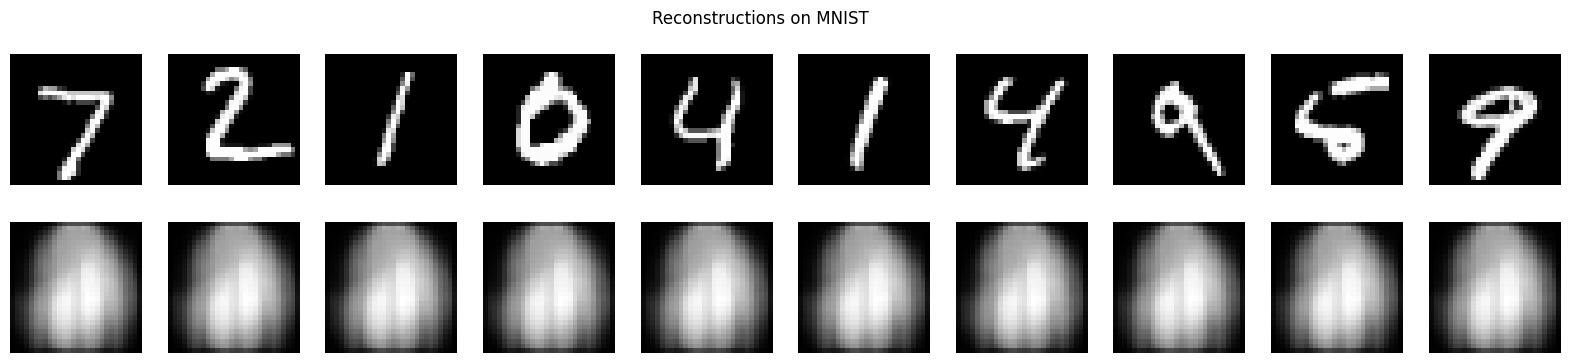

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


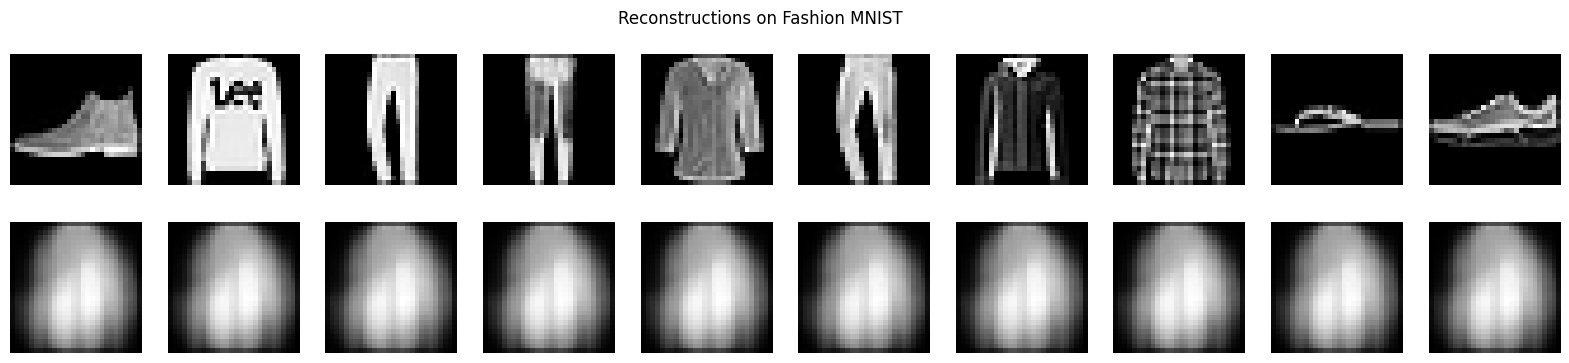

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


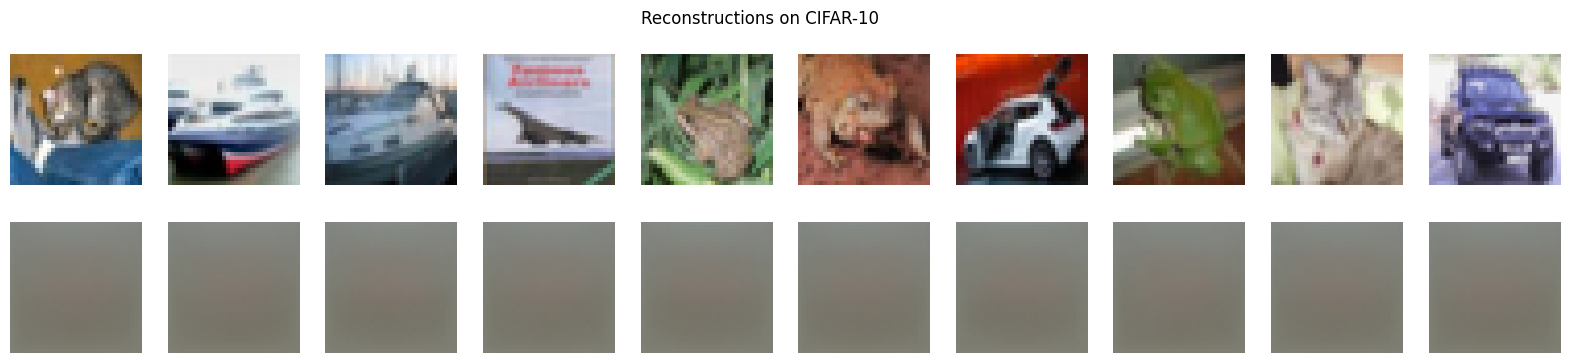

In [20]:
def plot_reconstructions(model, test_data, dataset_name):
    n = 10  # number of digits
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_data[i].squeeze(), cmap='gray')
        ax.axis('off')

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed = model.predict(np.expand_dims(test_data[i], axis=0))
        plt.imshow(reconstructed.squeeze(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f"Reconstructions on {dataset_name}")
    plt.show()

# MNIST Reconstructions
plot_reconstructions(vae, x_test_mnist, "MNIST")

# Fashion MNIST Reconstructions
plot_reconstructions(vae, x_test_fmnist, "Fashion MNIST")

# CIFAR-10 Reconstructions
plot_reconstructions(vae_cifar, x_test_cifar, "CIFAR-10")

In [21]:
# Evaluate MNIST
loss_mnist = vae.evaluate(x_test_mnist, x_test_mnist)
print(f"Reconstruction Loss on MNIST: {loss_mnist}")

# Evaluate Fashion MNIST
loss_fmnist = vae.evaluate(x_test_fmnist, x_test_fmnist)
print(f"Reconstruction Loss on Fashion MNIST: {loss_fmnist}")

# Evaluate CIFAR-10
loss_cifar = vae_cifar.evaluate(x_test_cifar, x_test_cifar)
print(f"Reconstruction Loss on CIFAR-10: {loss_cifar}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.0970
Reconstruction Loss on MNIST: 0.09717091172933578
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0870
Reconstruction Loss on Fashion MNIST: 0.08702262490987778
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0618
Reconstruction Loss on CIFAR-10: 0.061824530363082886
